The purpose of this exercise will be to build on the housing price model we worked on last time. We will be exploring additional synthic features as well as a looking at different methods of model customization using Tensors and the FTRL optimization algorithm

In [33]:
from __future__ import print_function
import math
from IPython import display


from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import metrics


import tensorflow as tf
from tensorflow.python.data import Dataset 

tf.logging.set_verbosity(tf.logging.ERROR)

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))



Just like last time, make some use of functional programming to extract our feature and target sets respectively. (*NOTE: I decided to leave out many of the comments for the operations I thought were commented enough in the previous exercises.)

In [2]:
"""Pre-processes input features from California Housing Dataset
    Args:
        california_housing_dataframe: A pandas dataframe with
        data from the California Housing Dataset
    Returns:
        A dataframe containing the features to be used for the model
        including synthetic features

"""
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[[
        "latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"
    ]]
    
    processed_features = selected_features.copy()
    
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"]/
        california_housing_dataframe["population"])
    
    return processed_features


""" Prepare target features or labels
    Args:
        california_housing_dataframe: A pandas dataframe with
        data from the California Housing Dataset
    Returns:
        A pandas dataframe containing target features

"""
def preprocess_targets(california_housing_dataframe):

    output_targets = pd.DataFrame()
    
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"]/1000)
    
    return output_targets

    
    


Next we partition the data and display the results just to make sure we didn't make any silly mistakes.

In [3]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary")
display.display(training_examples.describe())

print("Validation examples summary")
display.display(validation_examples.describe())

print("Training targets summary")
display.display(training_targets.describe())

print("Validation targets summary")
display.display(validation_targets.describe())

Training examples summary


latitude  longitude  housing_median_age  total_rooms  total_bedrooms  \
count   12000.0    12000.0             12000.0      12000.0         12000.0   
mean       35.6     -119.6                28.5       2644.4           540.3   
std         2.1        2.0                12.6       2196.0           426.0   
min        32.6     -124.3                 1.0          8.0             1.0   
25%        33.9     -121.8                18.0       1467.0           297.0   
50%        34.3     -118.5                29.0       2130.0           433.0   
75%        37.7     -118.0                37.0       3149.2           649.0   
max        42.0     -114.3                52.0      37937.0          6445.0   

       population  households  median_income  rooms_per_person  
count     12000.0     12000.0        12000.0           12000.0  
mean       1427.7       501.8            3.9               2.0  
std        1164.4       387.4            1.9               1.1  
min           3.0         1.0            0.5               0.1  
25%         793.0       282.0            2.6               1.5  
50%        1166.0       409.0            3.5               1.9  
75%        1718.0       605.0            4.8               2.3  
max       35682.0      6082.0           15.0              41.3

Validation examples summary


latitude  longitude  housing_median_age  total_rooms  total_bedrooms  \
count    5000.0     5000.0              5000.0       5000.0          5000.0   
mean       35.6     -119.6                28.7       2641.8           537.3   
std         2.1        2.0                12.7       2141.0           410.5   
min        32.5     -124.3                 2.0          2.0             2.0   
25%        33.9     -121.8                18.0       1444.8           295.8   
50%        34.2     -118.5                29.0       2122.5           437.0   
75%        37.7     -118.0                37.0       3154.2           648.0   
max        41.9     -114.5                52.0      27700.0          4457.0   

       population  households  median_income  rooms_per_person  
count      5000.0      5000.0         5000.0            5000.0  
mean       1434.2       499.9            3.9               2.0  
std        1107.1       377.5            1.9               1.4  
min           6.0         2.0            0.5               0.0  
25%         781.0       279.0            2.6               1.5  
50%        1170.0       409.0            3.5               1.9  
75%        1739.2       606.0            4.8               2.3  
max       15037.0      4204.0           15.0              55.2

Training targets summary


median_house_value
count             12000.0
mean                206.9
std                 115.8
min                  15.0
25%                 119.8
50%                 180.4
75%                 264.2
max                 500.0

Validation targets summary


median_house_value
count              5000.0
mean                208.2
std                 116.4
min                  15.0
25%                 119.0
50%                 180.4
75%                 266.9
max                 500.0

Finally, we define the function to declare the data types of our features columns to pass into TF and the input_fn we have used in all our exercises thus far

In [4]:
"""Construct TF feature columns

    Args:
        input_features: Names of input features to use
    Returns: 
        set of feature columns

"""
def construct_feature_columns(input_features):
    
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])




"""Trains a linear regression model.
    Args: 
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Int size of batches to be passed to the model
        shuffle: Boolean of whether to shuffle the data
        epochs: Int Number of epochs for which data should be repeated.
            default value = None
    Returns:
        Tuple of (features, labels) for the next data batch
    
""" 
#This is the same function we used in our last exercise.
def my_input_fn(features, targets, batch_size = 1, shuffle=True, num_epochs = None):
    
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size = 10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels
    

Now, lets talk about a variation of the gradient descent based optimization algorithm we've used so far. Most of the models we've explore have involved a relatively few number of variables but when extending to much higher dimensions, we can use a variation called FTRL ("Follow-The-Ring-Leader") optimization.

### FTRL
This algorithm does a few things differently from our typical gradient descent algorithm (the differences of which I wont go into for 2 reasons. Number one, they are beyond the scope of the exerces. Number two, well, I dont completely understand all the components of the algorithm myself). What you need to know is this:

It has the benefit of scaling the learning rate for each respective different coefficients. This helps us with the sparse weights if some features rarely take non-zero values. This essentially leads to sparse coefficent vectors, shrinking memory usage and making it extremely scalable for feature vectors with millions or even billions of dimensions! 

I am certainly no master of convex optimization methods but for those inclined and with the appropriate domain knowledge, you can read the paper [here](https://www.eecs.tufts.edu/%7Edsculley/papers/ad-click-prediction.pdf)
    

In [5]:
"""This function trains a linear regression model of multiple features

    Args:
        learning_rate: A 'float', learning rate
        steps: A non-zero 'int', total training steps taken (each step is forward
            and backward pass using single batch)
        batch_size: A non-zero 'int', the batch size
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
            
    Returns:
        A LinearRegressor object trained on training data
        Plots RMSE value at each training period step 
        Plots learned regression line at each training period

"""
def train_model(learning_rate, steps, batch_size, feature_columns, 
                training_examples, training_targets, validation_examples, 
                validation_targets):
    
        periods = 10
        steps_per_period = steps/periods
        
        #Now we define the Linear Regressor optimizer as FTRL optimizer
        my_optimizer = tf.train.FtrlOptimizer(learning_rate = learning_rate)
        my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
        linear_regressor = tf.estimator.LinearRegressor(
            feature_columns=feature_columns,
            optimizer=my_optimizer
        )
        
        training_input_fn = lambda: my_input_fn(training_examples,
                                                training_targets["median_house_value"],
                                                batch_size = batch_size)
        
        predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                        training_targets["median_house_value"],
                                                        num_epochs = 1,
                                                        shuffle=False)
        
        predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                          validation_targets["median_house_value"],
                                                          num_epochs = 1,
                                                          shuffle = False)
        
        print("Training_model...")
        print("RMSE (on training data): ")
        training_rmse = []
        validation_rmse = []
        
        for period in range(0, periods):
            
            #train model, starting from prior state
            linear_regressor.train(
                input_fn = training_input_fn,
                steps = steps_per_period)
            
            #compute predictions
            training_predictions = linear_regressor.predict(input_fn = predict_training_input_fn)
            training_predictions = np.array([item['predictions'][0] for item in training_predictions])
            
            validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fn)
            validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
            
            #compute training & validation loss metrics
            training_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(training_predictions, training_targets))
            
            validation_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(validation_predictions, validation_targets))
            
            #print current loss
            print(" period %02d : %0.2f" % (period, training_root_mean_squared_error))
            
            #finally, append current loss metrics to each respective list
            training_rmse.append(training_root_mean_squared_error)
            validation_rmse.append(validation_root_mean_squared_error)
            
        print("Model training now finished!")
            
        
        # Output a graph of loss metrics over periods.
        plt.ylabel("RMSE")
        plt.xlabel("Periods")
        plt.title("Root Mean Squared Error vs. Periods")
        plt.tight_layout()
        plt.plot(training_rmse, label="training")
        plt.plot(validation_rmse, label="validation")
        plt.legend()

        return linear_regressor
    

Lets just run a basic model just as an insanity check. 

Training_model...
RMSE (on training data): 
 period 00 : 121.81
 period 01 : 124.13
 period 02 : 109.01
 period 03 : 107.36
 period 04 : 109.85
 period 05 : 107.72
 period 06 : 110.90
 period 07 : 106.74
 period 08 : 106.46
 period 09 : 105.41
Model training now finished!


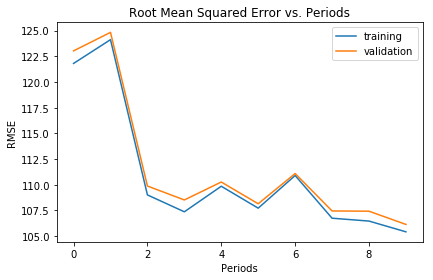

In [6]:
train_model(learning_rate = 0.1, steps = 500, batch_size = 100, 
           feature_columns = construct_feature_columns(training_examples),
           training_examples = training_examples,
           training_targets = training_targets,
           validation_examples = validation_examples,
           validation_targets = validation_targets)

### One Hot Encoding

Now, lets talk about one-hot encoding in feature design. Since pretty much every elementary statistical learning model requires numerical features, we need a method to convert discrete (strings, ordinal variables) features into some sort of numerical representation our model can understand. 

One-hot encoding to the rescue! Essentially what we are doing is, for each possible categorical value, we make a new binary feature of real values (0,1) wherein it takes the value of 1 if that particular example has that value and 0 if not. I illustrate with an example below:

| Example no. | feature_value |
|-------------|---------------|
| 0           |             2 |
| 1           |             0 |
| 2           |             1 |

| Example no. | feature_value_0 | feature_value_1 | feature_value_2 |
|-------------|-----------------|-----------------|-----------------|
| 0           |               0 |                0|                1|
| 1           |               1 |                0|                0|
| 2           |               0 |                1|                0|


The binary variable representation will give our linear regressor more information to work with rather than the somewhat arbitrary feature value 0,1,2 which may correspond to a myriad of interpretations qualitatively. 

Now, for the young and inexperienced econometricians and statisticians out there, you may be grinding your teeth at the fact that I included all 3 categories as feature variables. 

*Wait a second, what about perfect multicollinearity?*

Great Question! There are a few reasons why we don't have to worry too much about this problem.

1. Multicollinearity tends to only be a big issue in linear regression and can be minimized with regularization (which lends itself well to the FTRL optimization algorithm we are using).

2. In statistics/econometrics we are ofcourse concerned with predictive power but more so, the goal is to arrive at BLUE estimates of the coefficients (Best, Linear, Unbiased estimators). In machine learning, we are concerned primarily with predictive power so even if coefficients are warped by multicollinearity, its not of primary concern. 
   
For the readers that are completely confused about what I was just talking about, I leave a link to understanding BLUE [here](https://en.wikipedia.org/wiki/Gauss–Markov_theorem)



### Bucketized/Binned Features

Now, lets talk about another method of synthetic feature construction: Binning. Instead of creating a continuous feature variable, we split the feature values into seperate bins and create binary variables for whether each feature value falls into a particular bucket (then use one-hot encoding to create these binary variables). 

To define feature columns as bucketized features (which we need to do before passing the features into TF), we can declare the column as a bucketized_column which takes a numeric column as input and automatically transforms it to a bucketized feaure using bucket boundaries specified in the boundaries argument (pretty neat!). 



Before we apply this to our model, I wanted to *briefly* touch on different ways to bucketize our feature columns (at the risk of making this exercise too wordy). A linear model fit on bucketized features are able to fit any arbitrary coefficient to each bin, resulting in fits that can be very non-linear (and hence hold much stronger predictive power). 

There is also the additional consideration of how exactly to partition the buckets (equally spaced? The same number of samples in each bucket?) which lends itself well to alot of exploratory analysis. 

### Application #1

Alright, now enough with the explanations, lets apply what we just learnt to the model we have. 

In [29]:
"""This function creates quantile boundaries of a particular series given a number of buckets

    Args:
        feature_values: a Pandas series of which to create boundaries from
        num_buckets: an int number of buckets to seperate our feature_values into
        
    Returns:
        A list of boundaries we split our feature_values into
"""
def get_quantile_boundaries(feature_values, num_buckets):
    #creates evenly spaced quantile values (from 0 to 1) 
    boundaries = np.arange(1.0, num_buckets)/num_buckets
    #creates boundaries of feature value space given quantile values
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]




Before creating the boundaries, I wanted to do some exploratory analysis to see what an appropriate number of buckets would be for each feature we explore below. Since I want a reasonable amount of data in each bucket, we can try to approximate a good number of buckets to split each feature by. Lets take a look at the overall distribution to get a better sense of the number of buckets that may be appropriate for each feature. 
    


In [42]:
sns.set(style = "whitegrid")
training_examples.describe()



latitude  longitude  housing_median_age  total_rooms  total_bedrooms  \
count   12000.0    12000.0             12000.0      12000.0         12000.0   
mean       35.6     -119.6                28.5       2644.4           540.3   
std         2.1        2.0                12.6       2196.0           426.0   
min        32.6     -124.3                 1.0          8.0             1.0   
25%        33.9     -121.8                18.0       1467.0           297.0   
50%        34.3     -118.5                29.0       2130.0           433.0   
75%        37.7     -118.0                37.0       3149.2           649.0   
max        42.0     -114.3                52.0      37937.0          6445.0   

       population  households  median_income  rooms_per_person  
count     12000.0     12000.0        12000.0           12000.0  
mean       1427.7       501.8            3.9               2.0  
std        1164.4       387.4            1.9               1.1  
min           3.0         1.0            0.5               0.1  
25%         793.0       282.0            2.6               1.5  
50%        1166.0       409.0            3.5               1.9  
75%        1718.0       605.0            4.8               2.3  
max       35682.0      6082.0           15.0              41.3

Latitude and Longitude lend themselves well to being binned into 10 bins (10 degrees), as does housing median age. For rooms_per_person and median_income, those pesky outliers make it a bit more difficult. 5-6 bins seems alright however, so we get enough of a variation. 

In [43]:
"""This function constructs our TF feature columns

    Returns:
        A set of feature columns to be used in our model

"""
def construct_feature_columns():
    t
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    #bucketize all the features
    bucketized_households = tf.feature_column.bucketized_column(
        #boundaries argument takes a vector of boundries (for k boundries, creates a k+1 element bucketized vector)
        households, boundaries = get_quantile_boundaries(
            training_examples["households"], 6))
    
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries = get_quantile_boundaries(
            training_examples["longitude"], 10))
    
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries = get_quantile_boundaries(
            training_examples["latitude"], 10))
    
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries = get_quantile_boundaries(
            training_examples["housing_median_age"], 10))
    
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries = get_quantile_boundaries(
            training_examples["median_income"], 5))
    
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries = get_quantile_boundaries(
            training_examples["rooms_per_person"], 5))
    
    feature_columns = set([
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person])
    
    return feature_columns

Training_model...
RMSE (on training data): 
 period 00 : 168.94
 period 01 : 142.66
 period 02 : 126.27
 period 03 : 115.23
 period 04 : 107.38
 period 05 : 101.51
 period 06 : 96.99
 period 07 : 93.36
 period 08 : 90.40
 period 09 : 87.93
Model training now finished!


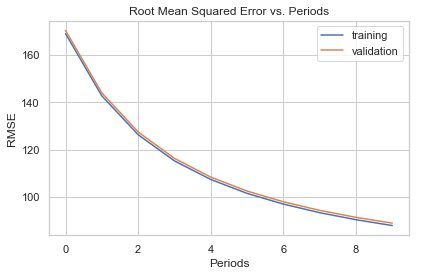

In [44]:
train_model(
    learning_rate = 1.0,
    steps = 500,
    batch_size = 100,
    feature_columns = construct_feature_columns(),
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets)

Alrighty, so we did a bit better here. Also much more stability with respect to the shape of our loss curve (always a good sign). I'm sure if the reader tinkers with the code more we could get this down quite a fair bit more but for the sake of the exercise, I'll be moving on to the next use case. 

### Application #2



Lets try out a feature cross to introduce some non-linearity, particularly in our binned longitude and latitude. What this essentially allows the model to do is well-define a city block, more realistically modelling the median house price of certain blocks over the others. Individually, the latitude and longitude does not hold as much information. 

Since the current feature columns API does not support continuous features, we bucketize our latitude and longitude as we did above and cross them. Using 10 bins for each feature, we get 100 crossed binary features, each of which getting its own seperate weight when we train the model. Re-writing our function, 

In [45]:
"""This function constructs our TF feature columns

    Returns:
        A set of feature columns to be used in our model

"""
def construct_feature_columns():
    
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    #bucketize all the features
    bucketized_households = tf.feature_column.bucketized_column(
        #boundaries argument takes a vector of boundries (for k boundries, creates a k+1 element bucketized vector)
        households, boundaries = get_quantile_boundaries(
            training_examples["households"], 6))
    
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries = get_quantile_boundaries(
            training_examples["longitude"], 10))
    
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries = get_quantile_boundaries(
            training_examples["latitude"], 10))
    
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries = get_quantile_boundaries(
            training_examples["housing_median_age"], 10))
    
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries = get_quantile_boundaries(
            training_examples["median_income"], 5))
    
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries = get_quantile_boundaries(
            training_examples["rooms_per_person"], 5))
    
    #We set the hash bucket size to 1000 to prevent hashing collisions for the implementation 
        #of the algorithm. Bigger tends to be better (lower probability of collisions). But bigger
            #also means we use more RAM. 
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size = 1000)
    
    feature_columns = set([
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person,
        long_x_lat])
    
    return feature_columns


Training_model...
RMSE (on training data): 
 period 00 : 137.64
 period 01 : 109.63
 period 02 : 95.83
 period 03 : 87.62
 period 04 : 82.28
 period 05 : 78.42
 period 06 : 75.60
 period 07 : 73.45
 period 08 : 71.82
 period 09 : 70.44
Model training now finished!


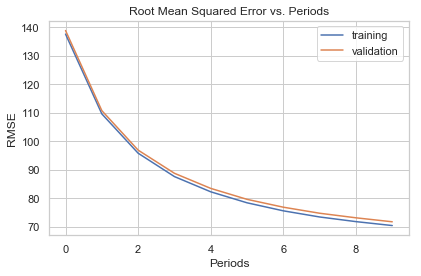

In [46]:
train_model(
    learning_rate=1.0,
    steps=1000,
    batch_size=50,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Within the first 4 periods, we already reach a loss lower than our last example. I hypothesize we could get pretty low here (remember that the RMSE is in units estimated *1000. So a loss of 70 does mean our average error in prediction is approximately $70,000). 

What if we crossed multiple columns? What about squaring some of the input features to capture more non-linearity? Varying the number of buckets? Maybe seperating the buckets in such a way that each bucket contains the same number of examples? We could also construct many other synthetic features (think rooms, bedrooms). 

As you can probably tell by now, there are no end to how complex we can make this model. But I will end with this. Linear regression only scratches the surface of other more complex statistical learning models we could use for this problem. 